<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/karras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate

# Setup

In [3]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os
# import lpips

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st
from accelerate import Accelerator
from datasets import load_dataset
from einops import rearrange

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
# from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

IMAGENET_MEAN = torch.tensor([0.4810, 0.4482, 0.3968])
IMAGENET_STD = torch.tensor([0.2760, 0.2683, 0.2813])

IN_CHANNELS_RGB = 3
IN_CHANNELS_GRAY_SCALE = 1

FMNIST_IN_CHANNELS = 1
FMNIST_OUT_CHANNELS = 1

Mounted at /content/drive


In [69]:
# 1. Callbacks and Learner related code below

def flatten_mse(yhat, targ): return F.mse_loss(yhat.flatten(), targ.flatten())

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

# 2. UNET and Attention related code.

def _pre_conv(ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni))
  layers.append(nn.Conv2d(ni, nf, kernel_size, stride = stride, padding = kernel_size//2, bias = True))
  return nn.Sequential(*layers)

def get_tembs(tsteps, nemb = 32, max_steps = 1000):
  nsteps = tsteps.shape[0]
  points = (-1*math.log(max_steps) * torch.linspace(0, 1, nemb//2)).to(tsteps.device)
  points_dist = tsteps[:, None] * points[None, :].exp()
  return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

class SM:
  def forward(self, *args, **kwargs):
    self.saved = super().forward(*args, **kwargs)
    return self.saved

class SConv(SM, nn.Conv2d): pass

class SelfAttention(nn.Module):
  def __init__(self, ni):
    super().__init__()
    self.kqv = nn.Linear(ni, 3*ni)
    self.norm = nn.GroupNorm(1, ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = ni

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      return rearrange(x, 'b c h w -> b (h w) c')
    if mode == 2:
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # Verify Shape
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return inp + x

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    ni = ni//n_heads
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return x

class MultiHeadSelfAttentionV2(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):

    x = inp
    x = self.norm(x)

    h, w = x.shape[-2], x.shape[-1]

    x = rearrange(x, 'b c h w -> b (h w) c')
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    k = rearrange(k, 'b s (c d) -> (b d) s c', d = self.n_heads)
    q = rearrange(q, 'b s (c d) -> (b d) s c', d = self.n_heads)
    v = rearrange(v, 'b s (c d) -> (b d) s c', d = self.n_heads)

    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    att_x = rearrange(att_x, '(b d) s c -> b s (c d)', d = self.n_heads)
    x = self.proj(att_x)
    out = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
    return out

class AttEmbResBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.emb_proj = nn.Linear(n_emb, 2*nf)
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.conv1 = _pre_conv(ni, nf, kernel_size, 1, act, norm)
    self.conv2 = _pre_conv(nf, nf, kernel_size, stride, act, norm)
    if attn: self.attn = MultiHeadSelfAttentionV2(nf, 8)

  def forward(self, x, t_emb):
    res = self.conv1(x)
    t_emb = self.emb_proj(t_emb)[:, :, None, None]  # bs, 2*nf
    scale, shift = t_emb.chunk(2, dim = 1)
    res = res + res * scale + shift
    res = self.conv2(res)
    x = self.id_conv(x) + res
    if hasattr(self, 'attn'): x = x + self.attn(x)
    return x

class SAttEmbResBlock(SM, AttEmbResBlock): pass

class DownBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.layers = nn.ModuleList([SAttEmbResBlock(ni if i == 0 else nf, nf, n_emb = n_emb, act = act, norm = norm, attn = attn) for i in range(n_layers)])
    self.f_layer = SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1) if add_down == True else fc.noop

  def forward(self, x, t_emb):
    for layer in self.layers:
      x = layer(x, t_emb)
    return self.f_layer(x)

  def get_acts(self):
    acts = [l.saved for l in self.layers]
    if hasattr(self.f_layer, 'saved'): acts.append(self.f_layer.saved)
    return acts

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, n_emb, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(AttEmbResBlock(inc, nf, n_emb = n_emb, act = act, norm = norm, attn = attn))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups, t_emb):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1), t_emb)
    return self.up(x)

class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = FMNIST_IN_CHANNELS, out_channels = FMNIST_OUT_CHANNELS,
                                                    nfs = [64, 128, 256, 512], n_layers = 2, emb_dim = 16, attn_start = 2, n_classes = 10):
    super().__init__()
    self.emb_dim = emb_dim
    n_emb = nfs[0]*4
    self.emb_mlp = nn.Sequential(nn.Linear(emb_dim, n_emb, bias = True),
                                 nn.BatchNorm1d(n_emb),
                                 nn.Linear(n_emb, n_emb, bias = True))

    self.c_emb = nn.Embedding(n_classes, n_emb)

    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(DownBlock(ni, nf, n_emb = n_emb, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True, attn = True if i >= attn_start else False))
      ni = nf

    self.downs = nn.Sequential(*downs)

    cross = [AttEmbResBlock(nfs[0], nfs[0], n_emb = n_emb, attn = False)]
    for i, cnf in enumerate(nfs):
      cross += [AttEmbResBlock(cnf, cnf, n_emb = n_emb, attn = True if i >= attn_start else False) for j in range(n_layers + 1 if i < len(nfs) - 1 else n_layers)]
    self.cross = nn.ModuleList(cross)

    self.mid_c = AttEmbResBlock(nf, nf, n_emb = n_emb, attn = True)

    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, n_emb = n_emb, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1, attn = True if i <= attn_start else False))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels) # EmbResBlock(nf, nf, n_emb = n_emb)

  def forward(self, inp):
    x, ts, ys = inp

    tembs = get_tembs(ts, self.emb_dim).to(x.device)

    t_emb = self.emb_mlp(tembs) # bs, 4*nfs[0]
    c_emb = self.c_emb(ys)
    emb = t_emb + c_emb
    x = self.first_c(x)
    acts = [x]
    for block in self.downs:
      x = block(x, emb)
    x = self.mid_c(x, emb)
    # acts += [i.saved for j in self.downs for i in j]
    for i in self.downs: acts += i.get_acts()
    n_acts = [cr(act, emb) for cr, act in zip(self.cross, acts)]
    for up in self.ups: x = up(x, n_acts, emb)
    return self.final_c(x)

# 3. Code related to FID

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'


class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class FID:
  def __init__(self, model = None, targ = None):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

In [5]:
IMAGENET_IN_CHANNELS, IMAGENET_OUT_CHANNELS = 3, 3
FMNIST_IN_CHANNELS, FMNIST_OUT_CHANNELS = 1, 1

dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

# Data Ranges from -1 to 1
@inplace
def transformi(b): b['image'] = [((resize(to_tensor(o), (32, 32), antialias = True)) * 2. - 1.) for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Karras Training

In [6]:
sigs = []
for x, y in tqdm(dls.train):
  sigs.append(x.std().item())

import numpy as np
sigma_data = torch.tensor([np.mean(sigs)])
sigma_data

  0%|          | 0/235 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


tensor([0.6766], dtype=torch.float64)

In [36]:
sigs = (torch.randn(x.shape[0])* 1.2 - 1.2).exp().to(x.device)[:, None, None, None]
x, y = next(iter(dls.train))

In [64]:

def get_scales(sigmas):
  sigma_data = torch.tensor([0.46]).to(sigmas.device)
  total_var = sigma_data**2 + sigmas**2
  cin = 1/(total_var.sqrt())
  cout = sigmas * sigma_data/(total_var.sqrt())
  cskip = sigma_data**2/total_var

  return cin, cout, cskip

def karras_noisify(x, sigs = None):

  # 1. Generate sigmas
  # 2. scale the input
  # 3. calculate the target
  # return scaled input, sigmas and calculated target

  sigmas = (torch.randn(x.shape[0])* 1.2 - 1.2).exp().to(x.device)[:, None, None, None] if sigs == None else sigs
  cin, cout, cskip = get_scales(sigmas)
  noise = torch.rand_like(x)
  noisy_input = x + sigmas*noise

  x_in = cin*(noisy_input)
  x_out = (x - cskip*noisy_input)/cout

  return (x_in, sigmas.squeeze()), x_out


In [65]:
(xin, sigmas), xout = karras_noisify(x)
print(xin.mean(), xin.std(), xout.mean(), xout.std())

tensor(-0.3993) tensor(1.2724) tensor(-0.8515) tensor(0.9548)


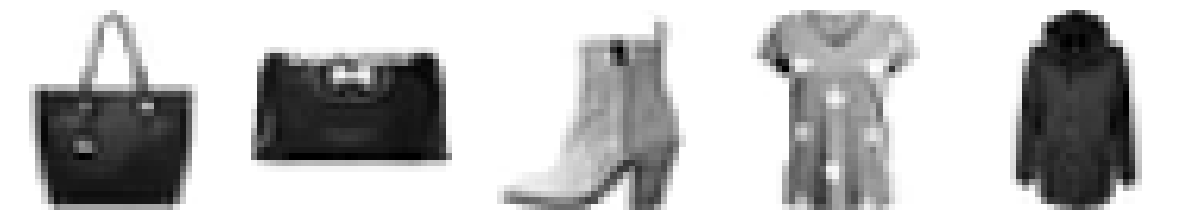

In [49]:
show_images(x[:5], ncols = 5)

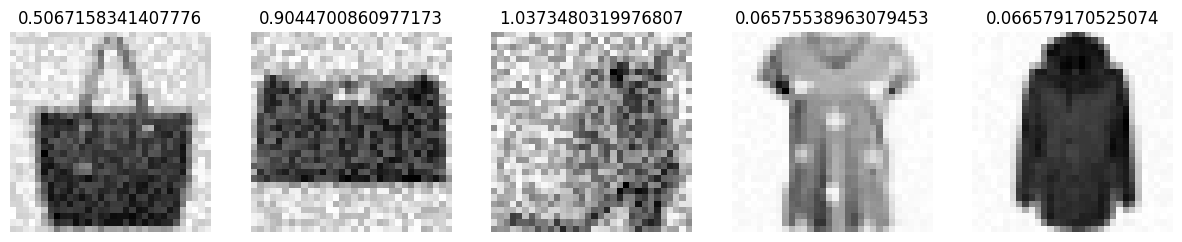

In [50]:
show_images(xin[:5], titles = [str(i.item()) for i in sigmas[:5]], ncols = 5)

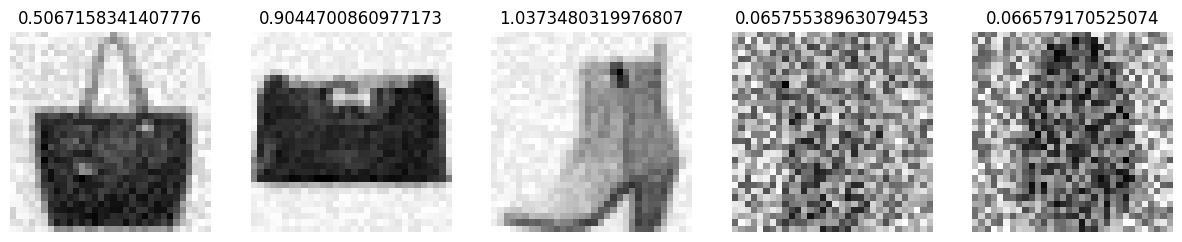

In [51]:
show_images(xout[:5], titles = [str(i.item()) for i in sigmas[:5]], ncols = 5)

In [70]:
class KarrasPrepCB(Callback):
  def before_batch(self, learn):
    x, y = learn.batch
    (xin, sigs), xout = karras_noisify(x)
    learn.batch = ((xin, sigs, y), xout)

In [71]:
# Test
(xin, sigs), xout = karras_noisify(x[:4])
model = DiffusionUNET(nfs = [64, 128, 256, 512])
out = model((xin, sigs, y[:4]))
out.shape

torch.Size([4, 1, 32, 32])

loss,epoch,train
0.294,0,train
10.349,0,eval
0.071,1,train
0.068,1,eval
0.058,2,train
0.050,2,eval
0.050,3,train
0.048,3,eval
0.045,4,train
0.046,4,eval


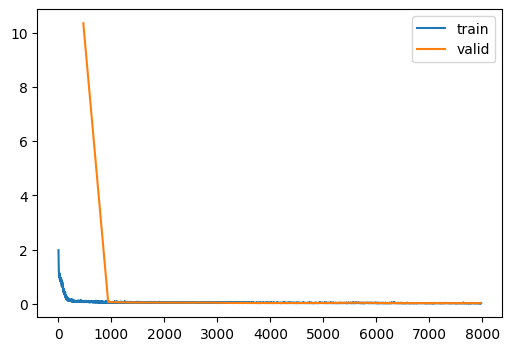

In [ ]:
lr_max, epochs = 2e-03, 20
dls = DataLoaders.from_dd(tds, batch_size = 128, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          KarrasPrepCB(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [ ]:
torch.save(learner.model, mdl_path/'conditional_diffusion_karras.pkl')